# High speed imaging pre processing

Load TIFF image sequence of spray data, etc, remove background and extract stable period for analysis.
    
    @author Daniel Duke <daniel.duke@monash.edu>
    @copyright (c) 2024 LTRAC
    @license GPL-3.0+
    @version 0.0.1
    @date 13/08/2024

    Laboratory for Turbulence Research in Aerospace & Combustion (LTRAC)
    Monash University, Australia


In [1]:
from pySciCam.pySciCam import ImageSequence # https://github.com/djorlando24/pySciCam
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
import numpy as np
import scipy.integrate
import time, os, gc
%matplotlib widget

## Load images to memory

In [2]:
# Define directory where images come from.
source_images = "/Users/dduke/Desktop/sampleImaging/mountPoint/"

In [3]:
# Load bkgnd
print("LOAD BACKGROUND")
B=ImageSequence(source_images, IO_threads=4, dtype=np.uint16, frames=(0,1000))

# Load event images in set range - can divide to chunk for ram limit
find_steady_start=False#True
find_steady_end=False

fr0=125000#100000#75000#50000#25000#1000
fr1=149000#75000#50000#25000

print("\nLOAD EVENT TIME SEQUENCE")
I=ImageSequence(source_images, IO_threads=8, dtype=np.uint16, frames=(fr0,fr1))

# coordinate vectors
y = np.arange(I.arr.shape[1])
x = np.arange(I.arr.shape[2])
t = np.arange(fr0,fr1)
gc.collect();

LOAD BACKGROUND
Reading /Users/dduke/Desktop/sampleImaging/mountPoint/
	Found 149001 images with extension .tif
	PythonMagick thinks the bit depth is uint12
	Reading files into memory...
40 tasks on 4 processors


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  10 tasks      | elapsed:    0.6s
[Parallel(n_jobs=4)]: Done  40 out of  40 | elapsed:    1.7s finished


Read 224.1 MiB in 1.8 sec
	Data in memory:	 (1000, 408, 384)
	Intensity range:	 0 to 53740 	 uint16
	Array size:	298.8 MB

LOAD EVENT TIME SEQUENCE
Reading /Users/dduke/Desktop/sampleImaging/mountPoint/
	Found 149001 images with extension .tif
	PythonMagick thinks the bit depth is uint12
	Reading files into memory...
80 tasks on 8 processors


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    4.6s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:   31.3s
[Parallel(n_jobs=8)]: Done  80 out of  80 | elapsed:   42.9s finished


Read 5378.9 MiB in 78.4 sec
	Data in memory:	 (24000, 408, 384)
	Intensity range:	 0 to 54556 	 uint16
	Array size:	7171.9 MB


## Background removal
This step is memory intensive as it requires conversion to 32bit float.
The 16bit int data will be deleted when this step is complete.

In [4]:
# Make the background reference image.
bkgnd = np.nanmean(B.arr,axis=0).astype(np.float32)
del B
bkgnd[bkgnd<=0] = np.nan

eps=1e-3 # divide-by-zero correction

# A function to operate on a single frame. Returns float32 using auto typing
# Convert transmission to extinction while removing background : ext = 1 - abs, abs = I_raw/I_bkgnd.
def doBkgndRemoval(I_raw): return 1.0 - (I_raw / (bkgnd+eps))

# Use multiple threads to speed up the floating point division calculation.
print("Background removal...")
Ilist = Parallel(n_jobs=-1,verbose=1)(delayed(doBkgndRemoval)(I.arr[n,...]) for n in range(I.N))
del I     # Remove original images to save memory.
gc.collect();

Background removal...


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 1100 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 3100 tasks      | elapsed:    9.7s
[Parallel(n_jobs=-1)]: Done 5900 tasks      | elapsed:   19.8s
[Parallel(n_jobs=-1)]: Done 9500 tasks      | elapsed:   36.7s
[Parallel(n_jobs=-1)]: Done 13900 tasks      | elapsed:   56.0s
[Parallel(n_jobs=-1)]: Done 19100 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 24000 out of 24000 | elapsed:  1.7min finished


In [5]:
# Convert from list back to 3D array (using dstack)

t_ = time.time()
print("Converting to 3D array...")
Ib = np.dstack(Ilist)
print(' - ',Ib.dtype)
del Ilist # Remove original list to save memory.

Ib = np.rollaxis(Ib,2,0) # Rearrange axes back to original form.
print(Ib.shape);
gc.collect();
print(" - elapsed time: %.1f s" % (time.time()-t_));

Converting to 3D array...
 -  float32
(24000, 408, 384)
 - elapsed time: 103.3 s


## Check time evolution
For finding useful analysis period of the time series

In [6]:
if find_steady_start or find_steady_end:
    t_ = time.time()
    print("Averaging and integrating spatially...");
    
    # Reslice near the nozzle to see time evolution
    # Average over streamwise coordinates.
    near_nozzle_profiles = np.nanmean(Ib,axis=-1).T
    # Integrate over transverse coordinates
    near_nozzle_integral = scipy.integrate.simpson(near_nozzle_profiles.T,x=y,axis=-1)
    print(" - elapsed time: %.1f s" % (time.time()-t_));

    # Use the integral data to find when the flow is 'active'
    threshold = 0.95 # higher value means less time samples but lower std dev.
    on = np.where(near_nozzle_integral > threshold*np.nanmax(near_nozzle_integral))[0]
    if find_steady_start: t0=on[0]
    else: t0=0
    if find_steady_end: t1=on[-1]
    else: t1=Ib.shape[0]-1
else:
    t0=0; t1=Ib.shape[0]-1

In [7]:
# Show the time evolution near the nozzle

if find_steady_start:
    fig=plt.figure()
    plt.suptitle(os.path.basename(source_images))
    ax=fig.add_subplot(211)
    plt.title("Time evolution near nozzle")
    plt.ylabel("Y [pixel]")
    plt.xlabel("Time [frame#]")
    h=ax.imshow(near_nozzle_profiles, cmap=plt.cm.gnuplot,vmin=0, aspect='auto')
    plt.colorbar(h)
    ax=fig.add_subplot(212)
    ax.plot(t, near_nozzle_integral, lw=1)
    plt.axvline(t[t0],c='k',lw=1,ls='--')
    plt.axvline(t[t1],c='k',lw=1,ls='--')
    plt.ylabel("Transverse integral")
    plt.xlabel("Time [frame#]");

## Save the usable part of the timeseries

Write the data to a file so that we can separate the analysis of the data from this post processing.

In [8]:
import h5py

t_=time.time()

grpName="frames_%i_%i" % (t[t0],t[t1])
filename = os.path.dirname(source_images)+"_extinction.h5"

print("Writing to %s:" % (filename))
with h5py.File(filename, 'a') as H: # 'a' = Append to existing data.

    # remove previously written group?
    if grpName in H: 
        del H[grpName] 
        print(' - replaced group ',grpName)
    else:
        print(' - created group ',grpName)
    
    G=H.create_group(grpName)
    G.create_dataset("time_frames",data=t[t0:t1],compression='lzf')
    G.create_dataset("x_pixel",data=x,compression='lzf'); print(" - wrote x")
    G.create_dataset("y_pixel",data=y,compression='lzf'); print(" - wrote y")
    G.create_dataset("bkgnd",data=bkgnd,compression='lzf'); print(" - wrote bkgnd")
    G.create_dataset("I",data=Ib[t0:t1,...],compression='lzf'); print(" - wrote I")

file_stats = os.stat(filename)
print(" - size now %.1f MB" % (file_stats.st_size / (1024 * 1024)))
print(" - elapsed time: %.1f s" % (time.time()-t_))

Writing to /Users/dduke/Desktop/sampleImaging/mountPoint_extinction.h5:
 - created group  frames_125000_148999
 - wrote x
 - wrote y
 - wrote bkgnd
 - wrote I
 - size now 78956.9 MB
 - elapsed time: 220.8 s


## Show some sample images

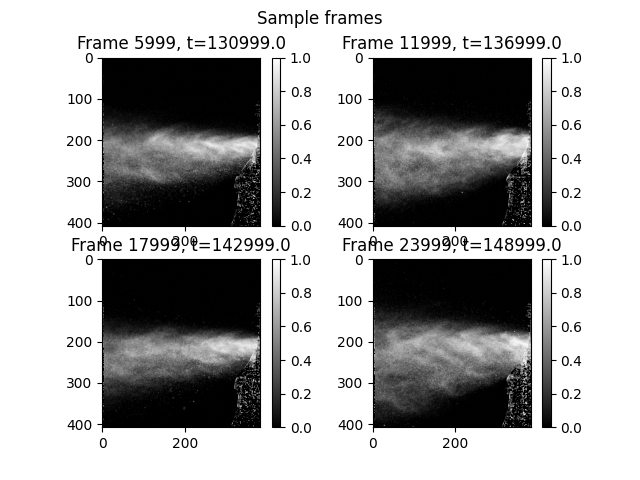

In [9]:
fig=plt.figure()
plt.suptitle("Sample frames\n"+os.path.basename(source_images))
some_frames = np.linspace(0,Ib.shape[0]-1,5)[1:]; i=0
for n in some_frames:
    ax=fig.add_subplot(221+i)
    h=ax.imshow(Ib[int(n),...],cmap=plt.cm.gray,vmin=0,vmax=1)
    plt.title("Frame %i, t=%.1f" % (n,t[int(n)]))
    plt.colorbar(h);
    i+=1